In [9]:
import os
import joblib
import pandas as pd

LOGS_DIR = "../logs"

# Detect any Optuna study file
for file in os.listdir(LOGS_DIR):
    if file.startswith("hpo_study_") and file.endswith(".pkl"):
        pkl_path = os.path.join(LOGS_DIR, file)
        print(f"📦 Found study: {pkl_path}")
        
        # Load Optuna study
        study = joblib.load(pkl_path)
        
        # Export to CSV
        csv_name = file.replace(".pkl", ".csv")
        csv_path = os.path.join(LOGS_DIR, csv_name)
        df = study.trials_dataframe()
        df.to_csv(csv_path, index=False)
        
        print(f"✅ Exported → {csv_path}")

print("🎯 Done! You can now use your visualization script.")

import joblib, pandas as pd, os

LOGS_DIR = "../logs"

pkl = os.path.join(LOGS_DIR, "hpo_study_cuda.pkl")
if not os.path.exists(pkl):
    pkl = os.path.join(LOGS_DIR, "hpo_study_cpu.pkl")

print(f"📦 Loading {pkl}")
study = joblib.load(pkl)
df = study.trials_dataframe()
csv = pkl.replace(".pkl", ".csv").replace("hpo_study_", "hpo_trials_")
df.to_csv(csv, index=False)
print(f"✅ Saved CSV: {csv}")


📦 Found study: ../logs\hpo_study_cpu.pkl
✅ Exported → ../logs\hpo_study_cpu.csv
📦 Found study: ../logs\hpo_study_cuda.pkl
✅ Exported → ../logs\hpo_study_cuda.csv
🎯 Done! You can now use your visualization script.
📦 Loading ../logs\hpo_study_cuda.pkl
✅ Saved CSV: ../logs\hpo_trials_cuda.csv


✅ All 5 figures saved in ../results/figures/ (no warnings, clean fonts)


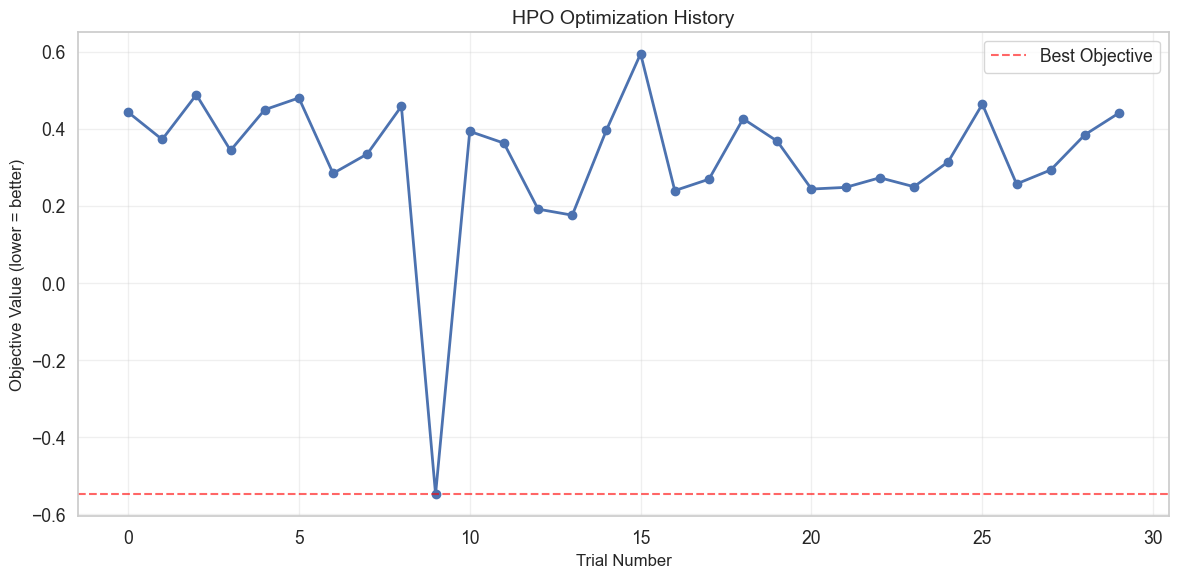

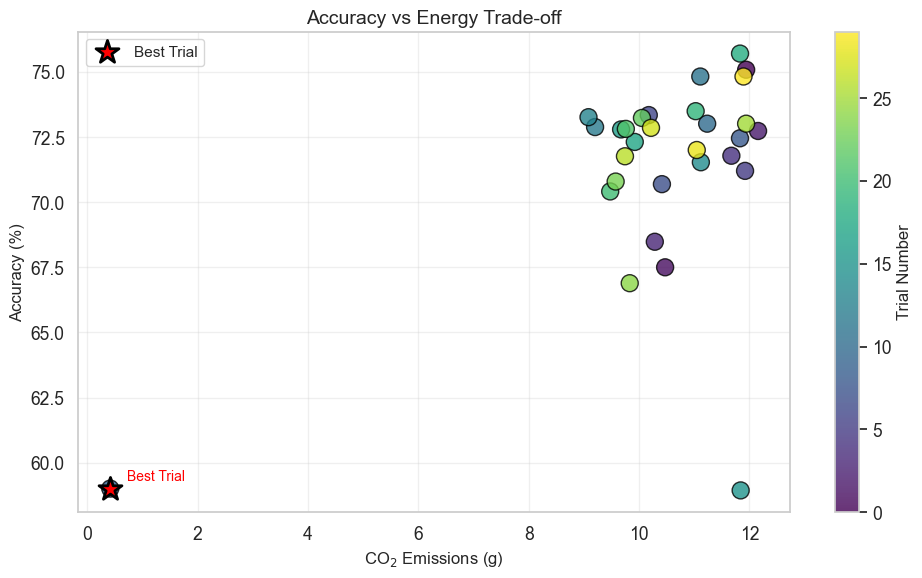

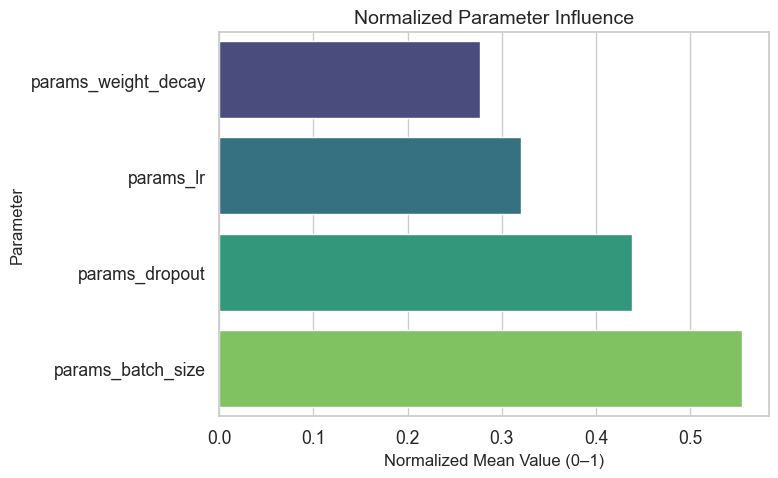

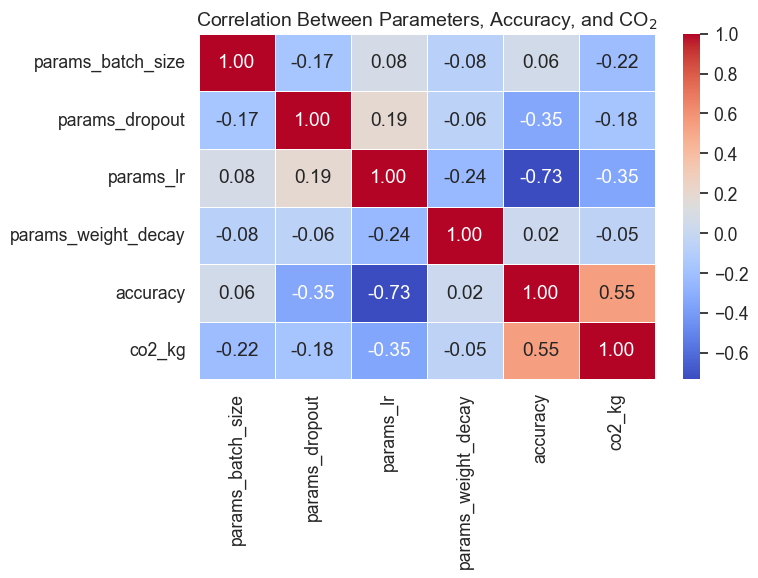

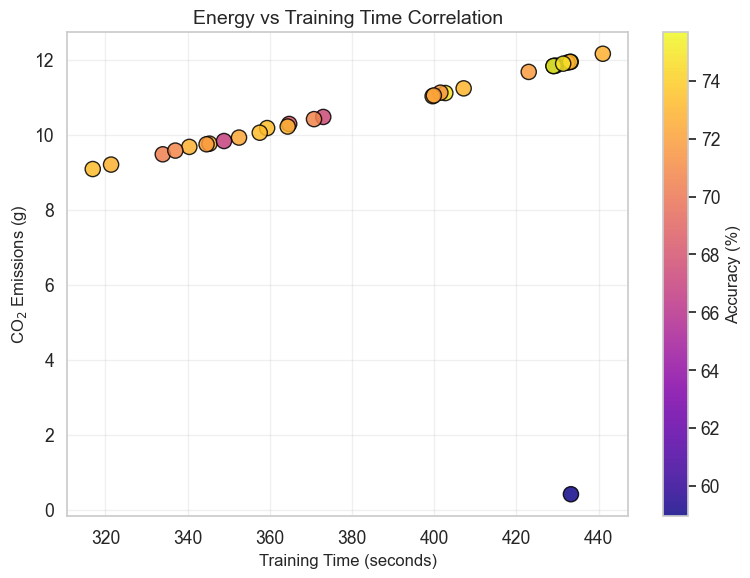

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🌱 Setup
LOGS_DIR = "../logs"
RESULTS_DIR = "../results/figures"
os.makedirs(RESULTS_DIR, exist_ok=True)

sns.set_theme(style="whitegrid", font_scale=1.15)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# 🌿 Load data
csv_path = os.path.join(LOGS_DIR, "hpo_trials_cuda.csv")
if not os.path.exists(csv_path):
    csv_path = os.path.join(LOGS_DIR, "hpo_trials_cpu.csv")

df = pd.read_csv(csv_path)

# Rename key columns
df.rename(columns={
    "number": "trial",
    "user_attrs_accuracy": "accuracy",
    "user_attrs_co2_kg": "co2_kg",
    "user_attrs_training_time": "training_time"
}, inplace=True)

# 1️⃣ HPO Optimization History
plt.figure(figsize=(12, 6))
plt.plot(df["trial"], df["value"], marker="o", linewidth=2)
plt.axhline(df["value"].min(), color="red", linestyle="--", alpha=0.6, label="Best Objective")
plt.xlabel("Trial Number")
plt.ylabel("Objective Value (lower = better)")
plt.title("HPO Optimization History")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/hpo_optimization_history.png", dpi=300)

# 2️⃣ Accuracy vs CO₂
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["co2_kg"] * 1000, df["accuracy"],
    c=df["trial"], cmap="viridis", s=150,
    alpha=0.8, edgecolors="black", linewidth=1
)
plt.colorbar(scatter, label="Trial Number")
plt.xlabel("CO$_2$ Emissions (g)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Energy Trade-off")
plt.grid(True, alpha=0.3)

best_idx = df["value"].idxmin()
best = df.loc[best_idx]
plt.scatter(best["co2_kg"] * 1000, best["accuracy"],
            s=300, color="red", marker="*",
            edgecolors="black", linewidth=2,
            label="Best Trial")
plt.text(best["co2_kg"] * 1000 + 0.3, best["accuracy"] + 0.3,
         "Best Trial", color="red", fontsize=10)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/hpo_pareto.png", dpi=300, bbox_inches="tight")

# 3️⃣ Normalized Parameter Influence
params = [c for c in df.columns if c.startswith("params_")]
if params:
    norm_df = df[params].copy()
    for c in params:
        norm_df[c] = (norm_df[c] - norm_df[c].min()) / (norm_df[c].max() - norm_df[c].min() + 1e-9)
    imp = norm_df.mean().reset_index()
    imp.columns = ["param", "mean_value"]
    imp = imp.sort_values("mean_value", ascending=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp, x="mean_value", y="param", hue="param", palette="viridis", legend=False)
    plt.title("Normalized Parameter Influence")
    plt.xlabel("Normalized Mean Value (0–1)")
    plt.ylabel("Parameter")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/hpo_param_importance.png", dpi=300)

# 4️⃣ Correlation Heatmap (Parameters × Accuracy × CO₂)
if params:
    corr_cols = params + ["accuracy", "co2_kg"]
    corr = df[corr_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Between Parameters, Accuracy, and CO$_2$")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/hpo_param_correlation.png", dpi=300)

# 5️⃣ CO₂ vs Training Time
if "training_time" in df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df["training_time"], df["co2_kg"] * 1000,
                c=df["accuracy"], cmap="plasma", s=120, alpha=0.85, edgecolors="black")
    plt.colorbar(label="Accuracy (%)")
    plt.xlabel("Training Time (seconds)")
    plt.ylabel("CO$_2$ Emissions (g)")
    plt.title("Energy vs Training Time Correlation")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/hpo_energy_vs_time.png", dpi=300)

print("✅ All 5 figures saved in ../results/figures/ (no warnings, clean fonts)")
